## Pipeline - SMOTE + Balanced RF + CV with KNN Imputation, along with Accuracy, Classification Report, Confusion Matrix and ROC - AUC Score. In feature engineering we have ER PR Bins.

Added - Reliability Curve, Brier Score, PR AUC Curve, 95% Confidence Intervals on ROC AUC and PR AUC Scores.

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils import resample

In [27]:
df = pd.read_csv("/content/canbrs_dataset.csv")
df.head()

,ID,V1,var2,var3,var4,V5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,Outcome
0,A1,77,2010,w1,m1,509,98,0,Unknown,Unknown,Unknown,Unknown,3,Positive,Negative,Negative,Dead
1,A2,82,2010,w1,w5,501,98,0,Yes,No,No,No,3,Positive,Negative,Negative,Dead
2,A3,42,2011,w1,s3,509,98,0,Yes,No,Yes,Yes,1,Negative,Negative,Negative,Dead
3,A4,72,2012,w1,w5,509,98,0,No,No,No,Yes,1,Negative,Negative,Negative,Dead
4,A5,85,2013,w1,w5,508,98,0,Yes,No,No,No,4,Positive,Positive,Positive,Dead


In [28]:
data = df.copy()

In [29]:
def bin_status(status):
    if pd.isnull(status) or status == 'Unknown':
        return np.nan
    elif status == 'Negative':
        return 0  # Negative -> 0
    elif status == 'Positive':
        return 1  # Positive -> 1
    else:
        return np.nan

data['ER_bin'] = data['v13'].apply(bin_status)
data['PR_bin'] = data['v14'].apply(bin_status)

data = data.drop(['v13', 'v14'], axis=1)

In [30]:
le_outcome = LabelEncoder()
data['Outcome'] = le_outcome.fit_transform(data['Outcome'])

label_encoders = {}

label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

data = data.round().astype(int)

if 'ID' in data.columns:
    data = data.drop('ID', axis=1)
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=42)

In [33]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Accuracy Scores: [0.85050251 0.94213836 0.94968553 0.94465409 0.93081761]
Mean Cross-Validation Accuracy: 0.9235596220094182


Accuracy: 0.9116666666666666

Classification Report:
               precision    recall  f1-score   support

       Alive       0.75      0.77      0.76       108
        Dead       0.95      0.94      0.95       492

    accuracy                           0.91       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.91      0.91      0.91       600



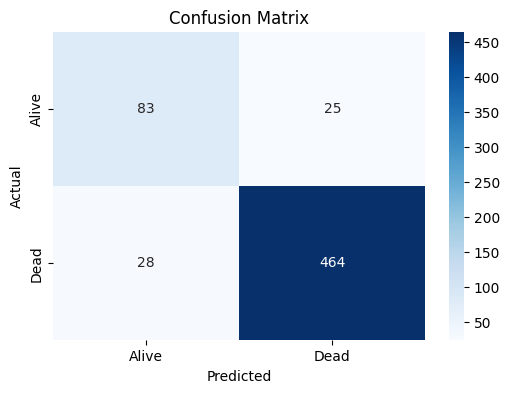

ROC AUC Score: 0.9408310749774165


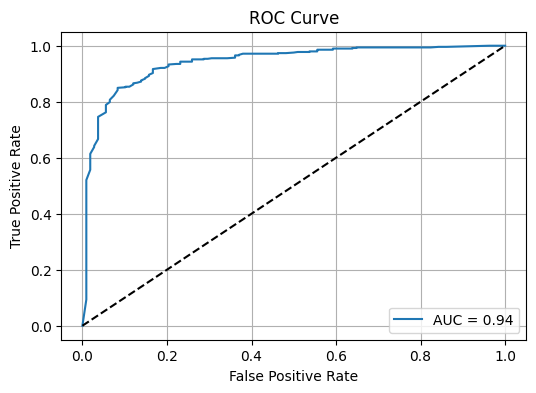

In [34]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_outcome.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_outcome.classes_, yticklabels=le_outcome.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

if y_pred_proba is not None:
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    print("ROC AUC Score:", auc_score)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    print("ROC AUC Score and Curve not available (model does not support probability estimates).")

Brier Score: 0.07165925932049211


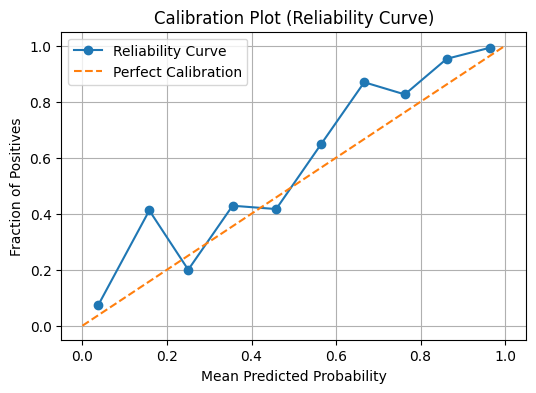

PR AUC Score: 0.9820953682962656


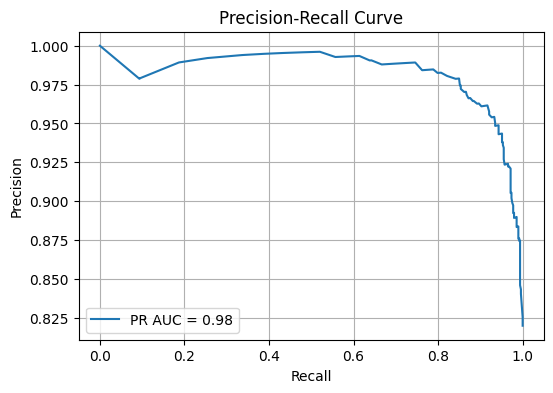

ROC AUC 95% CI: (0.914, 0.963)
PR AUC 95% CI: (0.968, 0.992)


In [35]:
if y_pred_proba is not None:
    brier_score = brier_score_loss(y_test, y_pred_proba)
    print("Brier Score:", brier_score)

    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(6,4))
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot (Reliability Curve)')
    plt.legend()
    plt.grid()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    print("PR AUC Score:", pr_auc)

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    n_bootstraps = 1000
    rng = np.random.RandomState(42)
    roc_auc_scores = []
    pr_auc_scores = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_test), len(y_test))
        if len(np.unique(y_test.iloc[indices])) < 2:
            continue
        score_roc = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
        score_pr = average_precision_score(y_test.iloc[indices], y_pred_proba[indices])
        roc_auc_scores.append(score_roc)
        pr_auc_scores.append(score_pr)

    roc_ci_lower = np.percentile(roc_auc_scores, 2.5)
    roc_ci_upper = np.percentile(roc_auc_scores, 97.5)
    pr_ci_lower = np.percentile(pr_auc_scores, 2.5)
    pr_ci_upper = np.percentile(pr_auc_scores, 97.5)

    print(f"ROC AUC 95% CI: ({roc_ci_lower:.3f}, {roc_ci_upper:.3f})")
    print(f"PR AUC 95% CI: ({pr_ci_lower:.3f}, {pr_ci_upper:.3f})")
